In [1]:
library(tidyverse)
library(cowplot)
library(ggrepel)
library(ggforce)
library(RColorBrewer)


`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [9]:
features_df <- read_csv('hetionet_features.csv')
metrics_df <- read_csv('calibration/calibration_metrics.csv')
bins_df <- read_csv('calibration/calibration_bins.csv')

full_df <- features_df %>%
    right_join(metrics_df, by = 'metaedge')

calibration_df <- full_df %>%
    full_join(bins_df, by = 'metaedge')

Parsed with column specification:
cols(
  density = col_double(),
  gini = col_double(),
  heterogeneity = col_double(),
  mean_var = col_double(),
  metaedge = col_character(),
  num_source = col_double(),
  num_target = col_double(),
  var = col_double()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_double(),
  auroc = col_double(),
  mxe = col_double(),
  w_mae = col_double(),
  feature = col_character(),
  metaedge = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_double(),
  feature = col_character(),
  bin_number = col_double(),
  num_edges = col_double(),
  bin_size = col_double(),
  bin_mean_feature = col_double(),
  bin_std_feature = col_double(),
  expected_percent_correct = col_double(),
  lower_ci = col_double(),
  upper_ci = col_double(),
  metaedge = col_character()
)


# 1. Distributions of features across metapaths

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


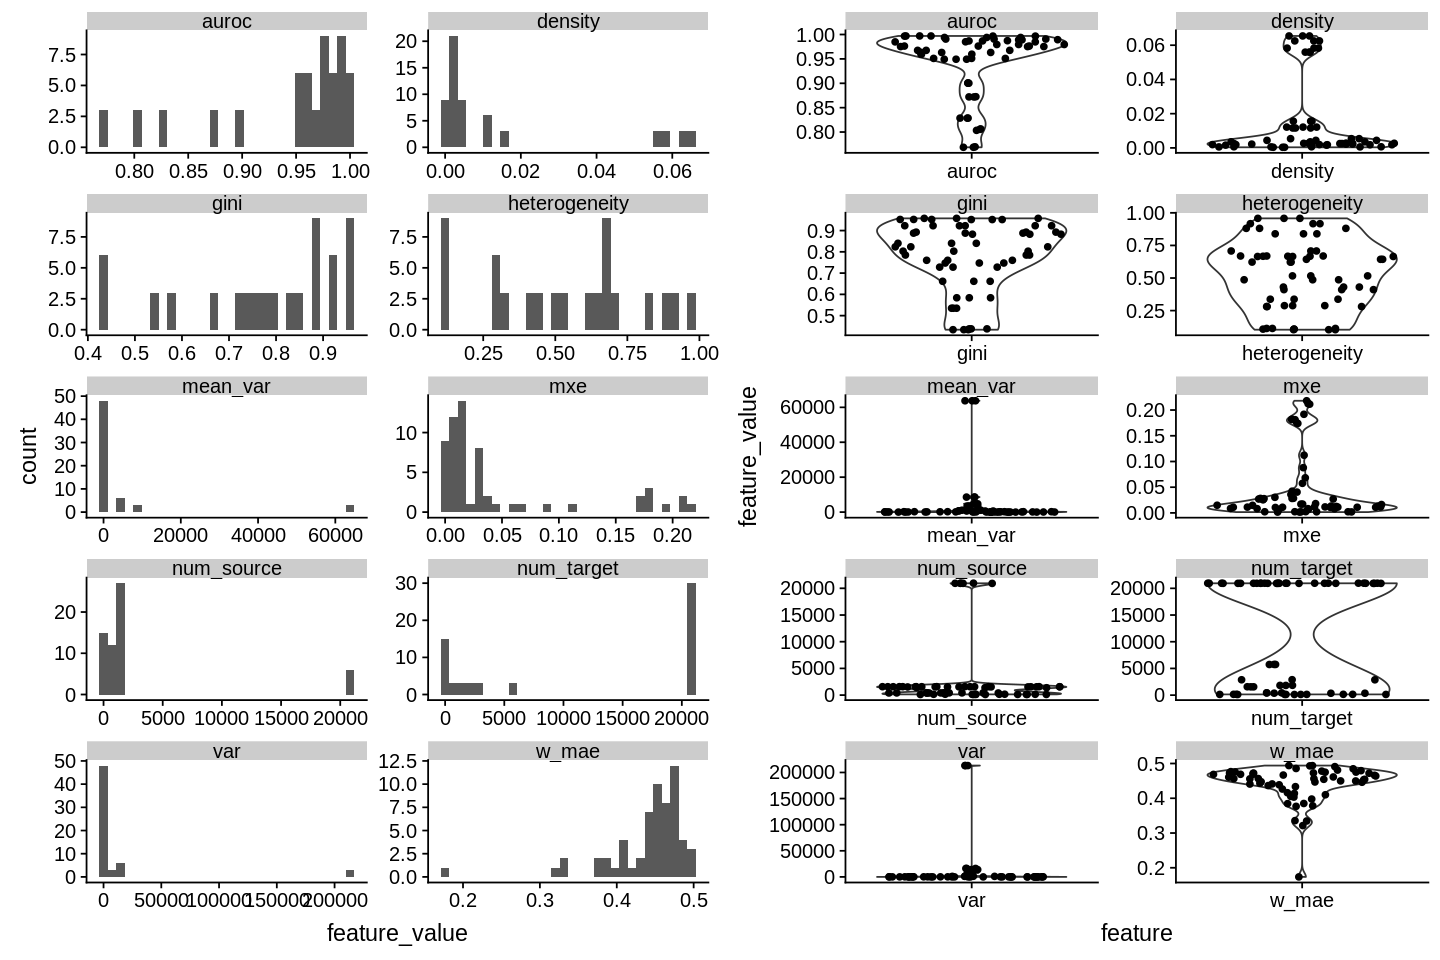

In [10]:
options(repr.plot.width=12, repr.plot.height=8)

horizontal_hists <- full_df %>%
    gather('feature', 'feature_value', density, gini, heterogeneity, mean_var, var, 
           num_source, num_target, auroc, mxe, w_mae) %>%
    ggplot(aes(x = feature_value)) +
    geom_histogram() +
    facet_wrap(vars(feature), scale = 'free', ncol = 2)


vertical_dists <- full_df %>%
    gather('feature', 'feature_value', density, gini, heterogeneity, mean_var, var, 
           num_source, num_target, auroc, mxe, w_mae) %>%
    ggplot(aes(x = feature, y = feature_value)) +
    geom_violin() +
    geom_sina() +
    facet_wrap(vars(feature), scale = 'free', ncol = 2)

plot_grid(horizontal_hists, vertical_dists, ncol = 2)

# 2. Relationships with XSwap AUROC

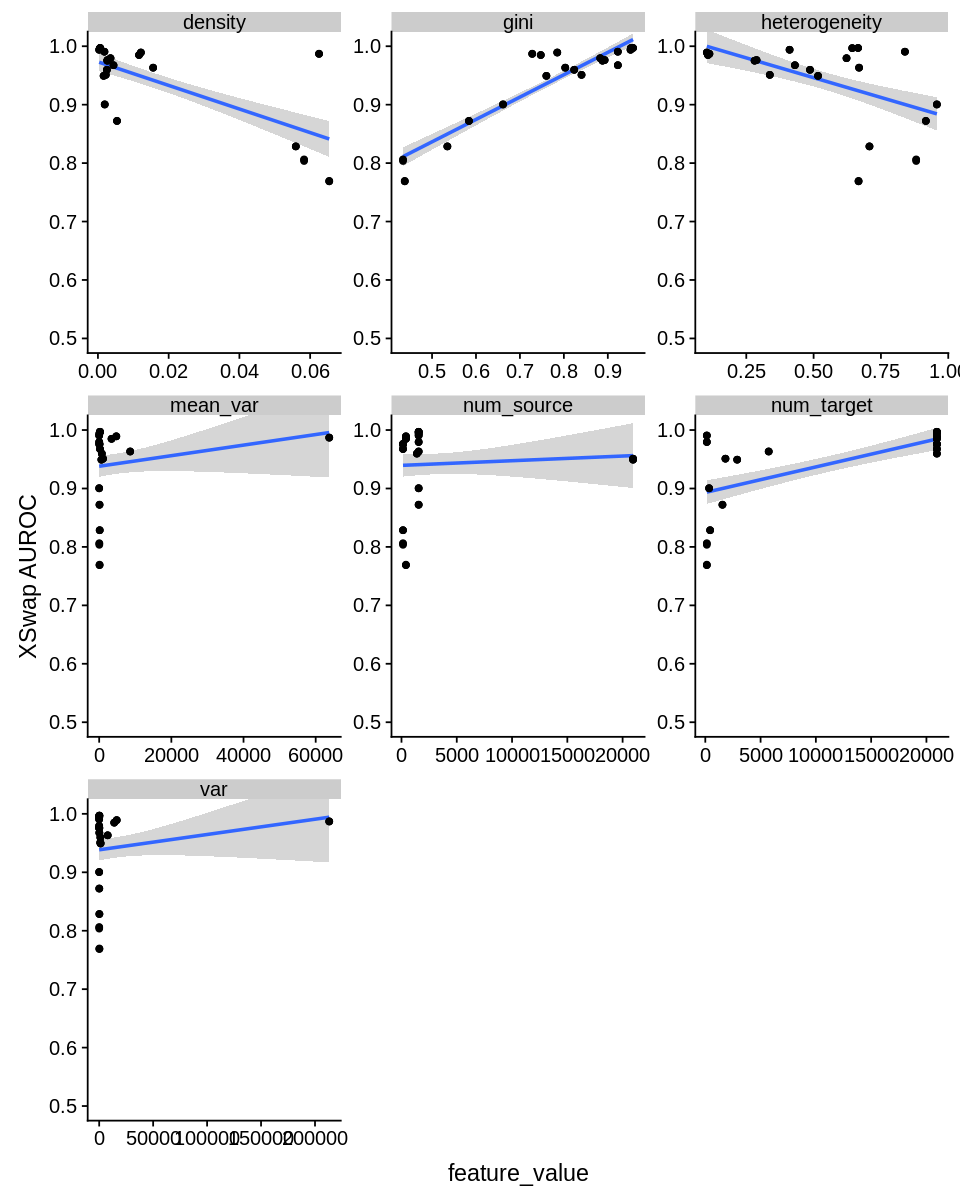

In [11]:
options(repr.plot.width=8, repr.plot.height=10)

full_df %>%
    gather('feature', 'feature_value', density, gini, heterogeneity, mean_var, var, 
           num_source, num_target) %>%
    ggplot(aes(x = feature_value, y = auroc)) +
    geom_smooth(method = 'lm', alpha = 0.4) +
    geom_point() +
    facet_wrap(vars(feature), scale = 'free', ncol = 3) + 
    coord_cartesian(ylim = c(0.5, 1)) +
    ylab('XSwap AUROC')

# 3. Track individual metapaths through features

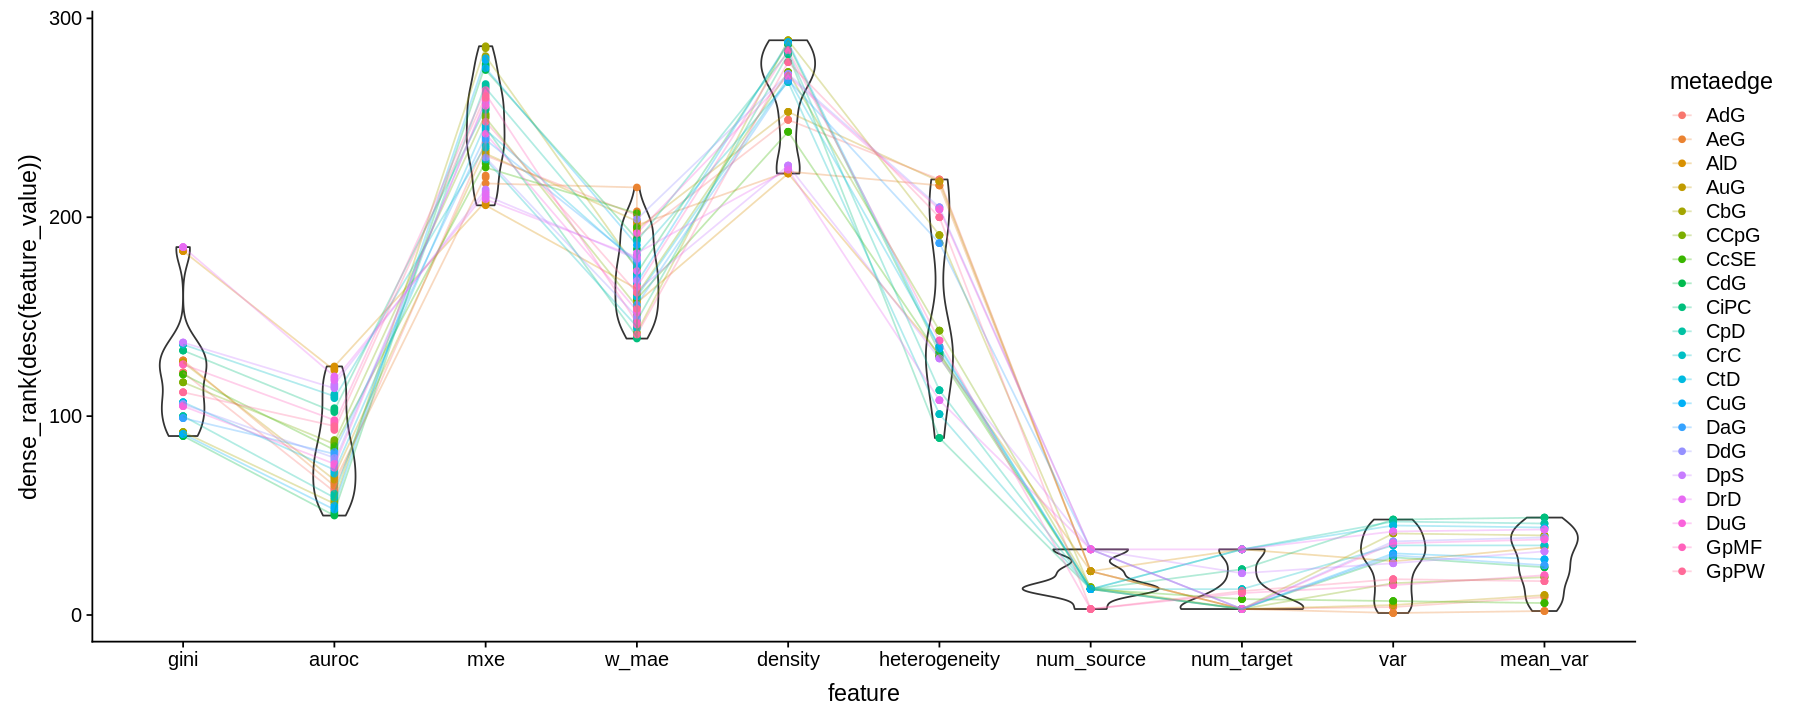

In [13]:
options(repr.plot.width=15, repr.plot.height=6)

pos_dodge <- position_identity()

full_df %>%
    gather('feature', 'feature_value',  density, gini, heterogeneity, mean_var, var, 
           num_source, num_target, auroc, mxe, w_mae) %>%
    mutate(
        feature = feature %>% factor(levels = c('gini', 'auroc', 'mxe', 'w_mae', 'density', 'heterogeneity', 
                                                'num_source', 'num_target', 'var', 'mean_var'))
    ) %>%
    ggplot(aes(x = feature, y = dense_rank(desc(feature_value)))) +
    geom_violin() +
    geom_point(aes(color = metaedge), position = pos_dodge) +
    geom_line(aes(group = metaedge, color = metaedge), alpha = 0.3, position = pos_dodge)

In [14]:
gini_heterogeneity_auc <- full_df %>%
    gather('feature', 'feature_value', gini, auroc, heterogeneity) %>%
    mutate(feature = feature %>% factor(levels = c('gini', 'xswap_auc', 'heterogeneity'))) %>%
    ggplot(aes(x = feature, y = feature_value)) +
    geom_boxplot(alpha = 0.75) +
    geom_point(aes(group = metaedge, color = metaedge)) +
    geom_line(aes(group = metaedge, color = metaedge), alpha = 0.5) +
#     geom_label_repel(data = full_df, aes(x = 'xswap_auc', y = xswap_auc, label = metaedge), nudge_x = 1) +
    theme_zietzm() +
    ylab('Value') +
    theme(axis.title.x=element_blank())


gini_auc <- full_df %>%
    gather('feature', 'feature_value', gini, auroc) %>%
    ggplot(aes(x = feature, y = feature_value)) +
    geom_boxplot(alpha = 0.75) +
    geom_point(aes(group = metaedge, color = metaedge)) +
    geom_line(aes(group = metaedge, color = metaedge), alpha = 0.5) +
#     geom_label_repel(data = full_df, aes(x = 'xswap_auc', y = xswap_auc, label = metaedge), nudge_x = 1) +
    theme_zietzm() +
    ylab('Value') +
    theme(axis.title.x=element_blank())

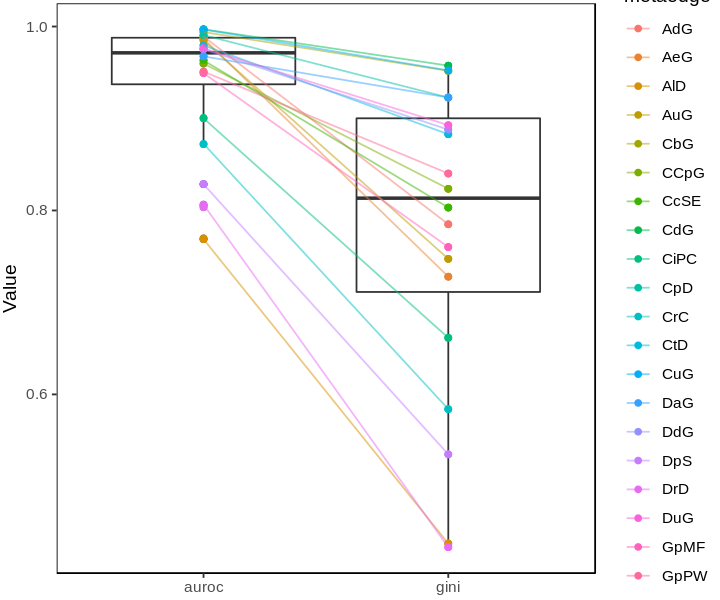

In [15]:
options(repr.plot.width=6, repr.plot.height=5)

gini_auc

In [16]:
pal = brewer.pal(24, 'Dark2')
pal = colorRampPalette(pal)(24)
# pie(rep(1, length(pal)), col = pal , main="") 

Warning message in brewer.pal(24, "Dark2"):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”

In [70]:
# Distribution of self-reconstruction AUROC
auroc_dist <- full_df %>%
    filter(feature == 'xswap_prior') %>%
    ggplot(aes(x = reorder(metaedge, auroc), y = auroc, fill = reorder(metaedge, auroc))) + 
    geom_col() +
    coord_flip(ylim = c(0.5, 1)) + 
    xlab('Metaedge') +
    ylab('XSwap prior AUROC') + 
    scale_fill_manual(values = pal) +
    scale_color_manual(values = pal) +
    theme_zietzm() + 
    theme(legend.position = "none", plot.margin = unit(c(0, 1, 0, 0), "cm"))

gini <- (
    ggplot(full_df %>% filter(feature == 'xswap_prior'), aes(x = gini, y = auroc))
    + geom_smooth(method = 'lm', alpha = 0.5)
    + geom_point(aes(color = reorder(metaedge, auroc)))
    + ylab('XSwap AUROC')
    + xlab('Degree Gini coefficient') 
    + theme_zietzm()
    + theme(legend.position = "none") + 
    scale_colour_manual(values = pal) + 
    scale_fill_manual(values = pal)
)

# Calibration plot
calibrations <- bins_df %>% 
    left_join(full_df, by = c('metaedge', 'feature')) %>%
    mutate(
        feature = feature %>% recode_factor(xswap_prior = 'XSwap prior', 
                                            scaled_degree = 'Scaled degree product',
                                            analytic_prior = 'Analytic approximation'),
        num_edges = density * (num_source * num_target),
    ) %>%
    filter(num_edges > 2000) %>%
    ggplot(aes(x = bin_mean_feature, y = expected_percent_correct, 
               ymin = lower_ci, ymax = upper_ci, color = reorder(metaedge, auroc))) +
    geom_abline(color = 'grey', linetype = 'dashed') +
#     geom_point(alpha = 0.5) +
    geom_line(alpha = 0.5, size = 1) +
    geom_errorbar(alpha = 0.75) +
    facet_wrap(vars(feature)) +
    scale_x_continuous(trans = 'sqrt') +
    scale_y_continuous(trans = 'sqrt') +
    xlab('Mean feature value') +
    ylab('Estimated true probability') +
    coord_equal() + 
    scale_fill_manual(values = pal) +
    scale_color_manual(values = pal) +
    theme_zietzm() + 
    theme(legend.position = "none")

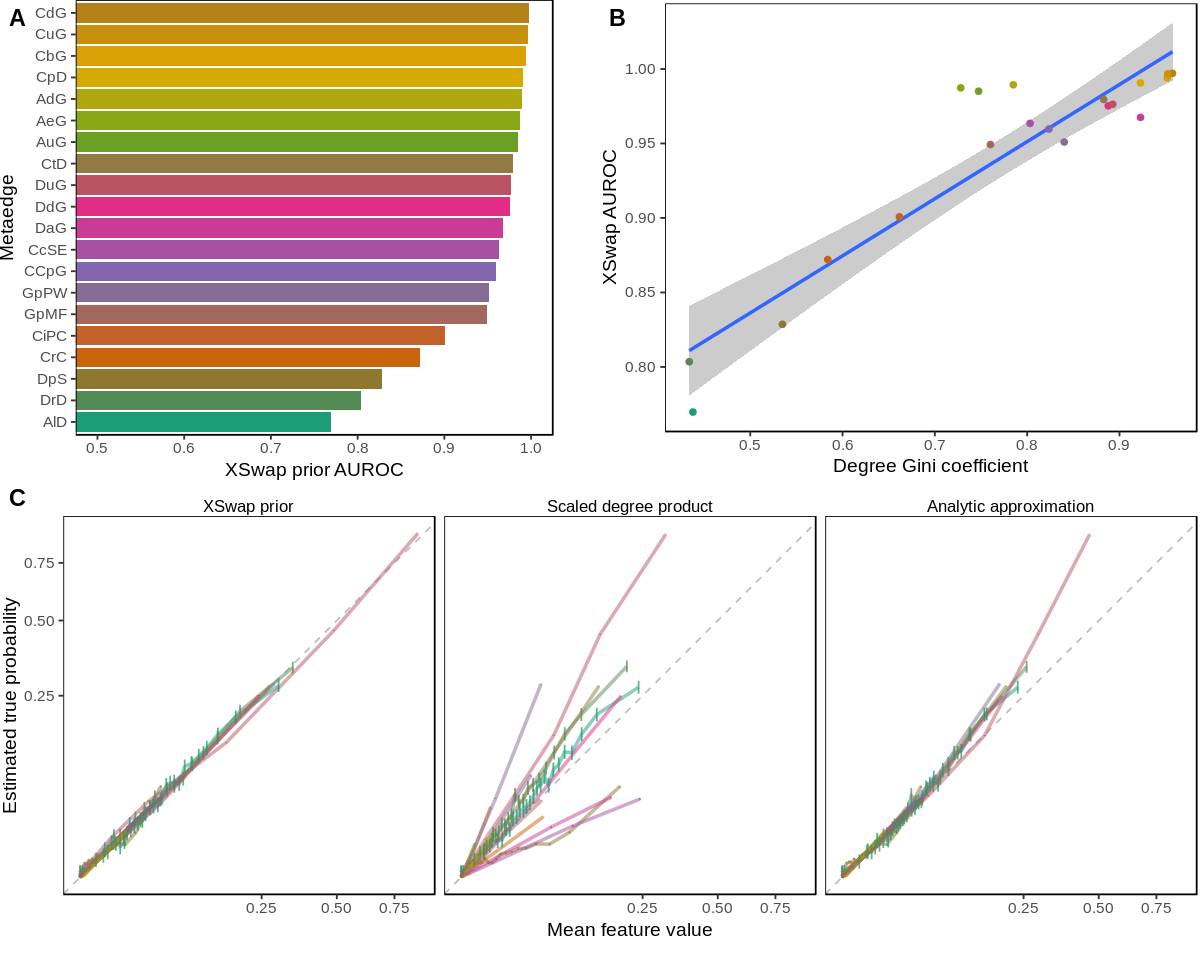

In [71]:
options(repr.plot.width=10, repr.plot.height=8)

top <- plot_grid(auroc_dist, gini, ncol = 2, labels = c("A", "B"))
full <- plot_grid(top, calibrations, ncol = 1, rel_heights = c(1, 1), labels = c("", "C"))

full

In [61]:
options(repr.plot.width=12, repr.plot.height=6)

full_metrics <- full_df %>%
mutate(
    feature = feature %>% recode_factor(xswap_prior = 'XSwap prior', 
                                        scaled_degree = 'Scaled degree',
                                        analytic_prior = 'Analytic'),
    num_edges = density * (num_source * num_target),
) %>%
filter(num_edges > 2000) %>%
mutate(color = reorder(metaedge, auroc)) %>%
gather('metric', 'value', auroc, mxe, w_mae) %>%
ggplot(aes(x = feature, y = value, group = metaedge, color = color)) +
geom_point() +
geom_line() +
facet_wrap(vars(metric), scales = 'free') +
scale_fill_manual(values = pal) +
scale_color_manual(values = pal) +
theme_zietzm() + 
theme(legend.position = "none")

average_metrics <- metrics_df %>%
    select(-X1, -metaedge) %>%
    group_by(feature) %>%
    summarize_all(.funs = list(mean)) %>%
    ungroup() %>%
    gather('metric', 'value', auroc, mxe, w_mae) %>%
    ggplot(aes(x = feature, group = feature, y = value, fill = feature)) +
    geom_col(position = 'dodge') +
    facet_wrap(vars(metric), scale = 'free') +
    theme_zietzm() + 
    theme(legend.position = "none")

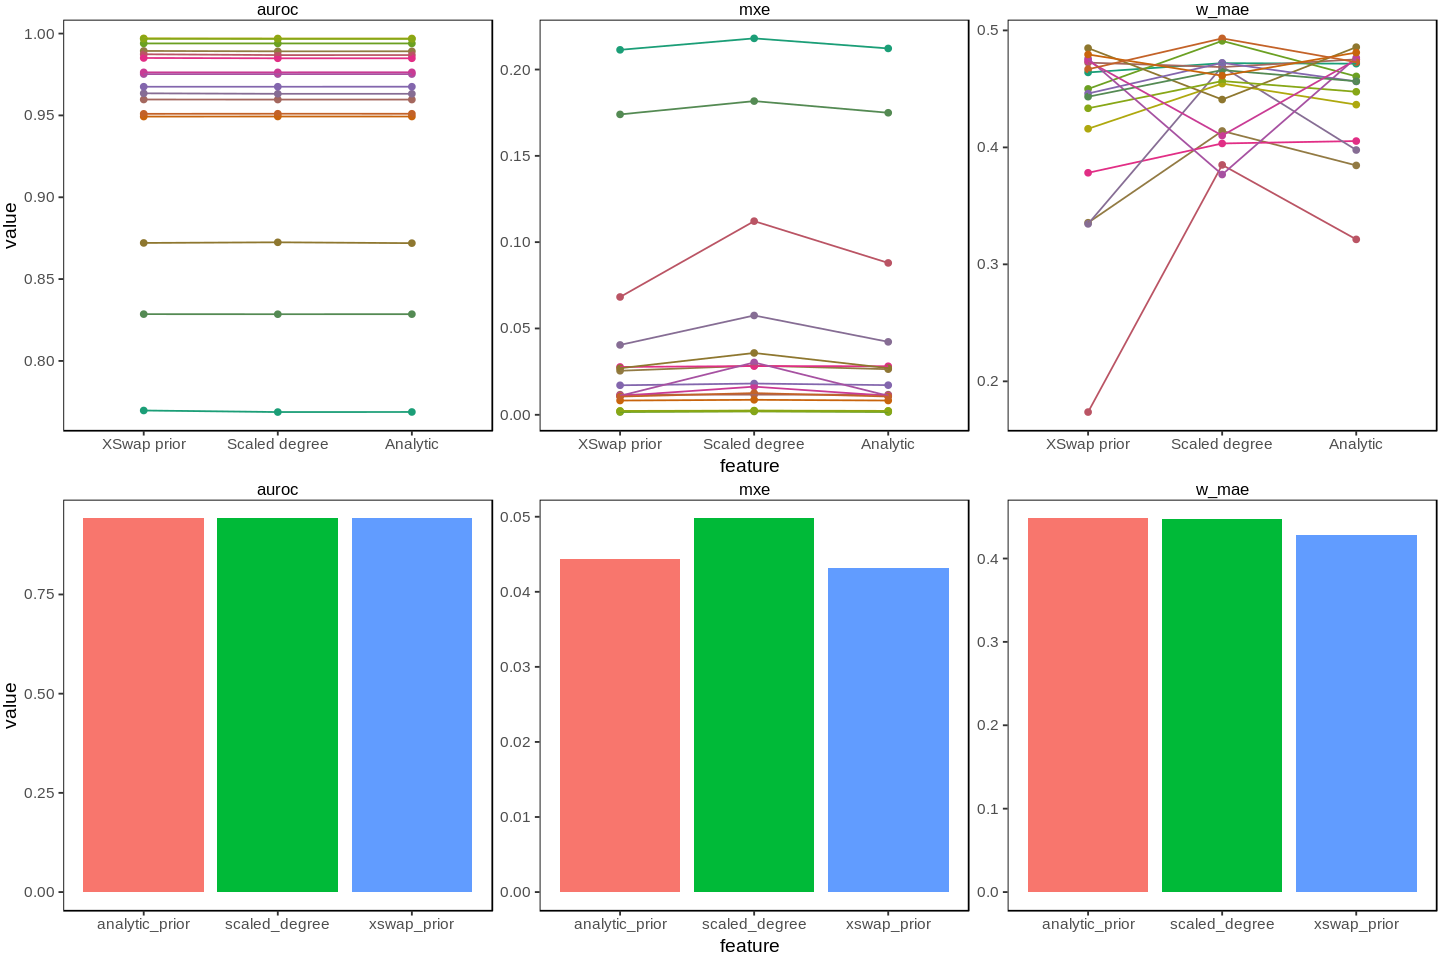

In [64]:
options(repr.plot.width=12, repr.plot.height=8)

plot_grid(full_metrics, average_metrics, ncol = 1)